## SOM_CV_data

This notebook trains the SOMs from the input data where there is a given GTD (either era5 or UK-ESM-1-0-LL piControl). From a specified number of folds in the cross-validation, the function trains and plots the SOM and associated trends from the training data. The SOM is then applied to the test dataset. This is done for each specified set of years.


Currently the assignment of BMUs to the test data is non-physical, despite similar patterns emerging in the SOM. This suggests that there is a problem with the ``Identify_BMU_from_codebook`` function.


In [3]:
import numpy as np
import scipy
import sys
import os
os.environ["PROJ_LIB"] = "/rds/general/user/kc1116/home/anaconda3/envs/zeus/share/proj"
import matplotlib as mpl
#mpl.use("Agg", warn=False)
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import glob
from scipy import stats
import SOM_trends_funcs as SOM_fn
import pandas as pd
import seaborn as sns

In [4]:
yrstrain_files = sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/training_yrs/*cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_5x4_EUR_10yrs_JJA_extd_zg_*"))
yrstrain_done = [int(file.split("LTDManom_pr_rc")[1].split("yrstrain")[0]) for file in yrstrain_files]


years_todo = []

for year in range(1,91):
    if year not in yrstrain_done:
        years_todo.append(year)
        
(years_todo), len((years_todo))

([], 0)

In [33]:
#test what years are missing from the SOM CV data which need to be run
dir_str="/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/10-fold/training_yrs/"##"/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM/z/crossval/10-fold/training_yrs/"
#/rds/general/project/nowack_graven/live/carl_som_index/data/UKESM1-0-LL_piControl/zg/crossval/10-fold/training_yrs/SOM_train_UKESM1-0-LL_r1i1p1f2_5x4_EUR_not1970-1979_JJA_extd_zg_LTDManom91yrstrain.nc

year_str_arr = ["1960-1969","1970-1979","1980-1989","1990-1999","2000-2009","2010-2019","2020-2029","2030-2039","2040-2049","2050-2059"]


for year_str in year_str_arr:
    
    file_list=sorted(glob.glob(f"{dir_str}*SOM_train_UKESM1-0-LL_r1i1p1f2_5x4_EUR_not{year_str}_JJA_extd_zg_LTDManom*"))#3yrstrain.nc"))
    years_done = sorted([int(file.split("LTDManom")[1].split("yrstrain")[0]) for file in file_list])
    #if len(file_list) != 37:
    print(year_str)
    for year in range(1,92):
        if year not in years_done:
            print(year)
    #print(years_done)
    print(len(file_list))


1960-1969
91
1970-1979
91
1980-1989
91
1990-1999
91
2000-2009
91
2010-2019
91
2020-2029
91
2030-2039
91
2040-2049
91
2050-2059
91


In [10]:
#dir_str=("/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/training_yrs/")
#"cv_crossvsF1_10-fold_era5_reanal_5x4_EUR_4yrs_JJA_extd_z_LTDManom_pr_rc9yrstrain.nc"

sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/training_yrs/*cv_crossvsF1_10-fold_era5_reanal_5x4_EUR_4yrs_JJA_extd_z_LTDManom_pr_rc*"))

['/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/training_yrs/cv_crossvsF1_10-fold_era5_reanal_5x4_EUR_4yrs_JJA_extd_z_LTDManom_pr_rc10yrstrain.nc',
 '/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/training_yrs/cv_crossvsF1_10-fold_era5_reanal_5x4_EUR_4yrs_JJA_extd_z_LTDManom_pr_rc11yrstrain.nc',
 '/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/training_yrs/cv_crossvsF1_10-fold_era5_reanal_5x4_EUR_4yrs_JJA_extd_z_LTDManom_pr_rc12yrstrain.nc',
 '/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/training_yrs/cv_crossvsF1_10-fold_era5_reanal_5x4_EUR_4yrs_JJA_extd_z_LTDManom_pr_rc13yrstrain.nc',
 '/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/training_yrs/cv_crossvsF1_10-fold_era5_reanal_5x4_EUR_4yrs_JJA_extd_z_LTDManom_pr_rc14yrstrain.nc',
 '/rds/general/project/nowack_graven/live/carl_som_index/data/z/c

In [14]:
GTD_str = "/rds/general/project/nowack_graven/live/carl_som_index/data/GTD_1979-2019_JJAextd.nc"

GTD = xr.open_dataset(GTD_str)['blocking']
GTD = GTD.sel(time=np.isin(GTD['time.season'], "JJA"))

In [3]:
GTD_2003=GTD.sel(time=np.isin(GTD['time.year'], [2003]))
GTD_2019=GTD.sel(time=np.isin(GTD['time.year'], [2019]))

In [4]:
GTD_2003[54:74], GTD_2019[28:38]

(<xarray.DataArray 'blocking' (time: 20)>
 array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0.])
 Coordinates:
   * time     (time) datetime64[ns] 2003-07-25T10:30:00 ... 2003-08-13T10:30:00,
 <xarray.DataArray 'blocking' (time: 10)>
 array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
 Coordinates:
   * time     (time) datetime64[ns] 2019-06-29T10:30:00 ... 2019-07-08T10:30:00)

In [5]:
AGP = xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/AGP/AGP_clusters_fin_era5_reanal_EUR_JJAextd_1979-2019.nc")['TM90_clusters'][:,:-1,:]>0
DG83 = xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/DG83/block_data/DG83_clusters_fin_era5_reanal_EUR_JJAextd_1979-2019.nc")['TM90_clusters']>0
S04 = xr.open_dataset(f"/rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_fin_era5_reanal_EUR_JJAextd_1979-2019.nc")['TM90_clusters'][:,:-1,:]>0

AGP = AGP.sel(time=np.isin(AGP['time.season'], "JJA"))
DG83 = DG83.sel(time=np.isin(DG83['time.season'], "JJA"))
S04 = S04.sel(time=np.isin(S04['time.season'], "JJA"))

In [15]:
AGP_mask_occ = [AGP_mask.sum(axis=1).sum(axis=1) > 0]

In [17]:
AGP_mask_occ, GTD

([<xarray.DataArray 'TM90_clusters' (time: 3772)>
  array([ True,  True,  True, ..., False, False, False])
  Coordinates:
    * time     (time) datetime64[ns] 1979-06-01T10:30:00 ... 2019-08-31T10:30:00],
 <xarray.DataArray 'blocking' (time: 3772)>
 array([1., 1., 1., ..., 1., 1., 1.])
 Coordinates:
   * time     (time) datetime64[ns] 1979-06-01T10:30:00 ... 2019-08-31T10:30:00)

In [100]:
AGP2003 = AGP.sel(time=np.isin(AGP['time.year'], [2003]))
AGP2019 = AGP.sel(time=np.isin(AGP['time.year'], [2019]))
AGP_blo_idx=np.where(np.array(AGP2003.sum(axis=1).sum(axis=1).values) > 0)
AGP2003['time'][AGP_blo_idx].values
AGP2003_occ=((AGP2003.sum(axis=1).sum(axis=1)>0)+1-1)
AGP2019_occ=((AGP2019.sum(axis=1).sum(axis=1)>0)+1-1)

In [101]:
S042003 = S04.sel(time=np.isin(S04['time.year'], [2003]))
S042019 = S04.sel(time=np.isin(S04['time.year'], [2019]))
S042003_occ=((S042003.sum(axis=1).sum(axis=1)>0)+1-1)
S042019_occ=((S042019.sum(axis=1).sum(axis=1)>0)+1-1)

In [116]:
DG832003 = DG83.sel(time=np.isin(DG83['time.year'], [2003]))
DG832019 = DG83.sel(time=np.isin(DG83['time.year'], [2019]))
DG832003_occ=((DG832003.sum(axis=1).sum(axis=1)>0)+1-1)
DG832019_occ=((DG832019.sum(axis=1).sum(axis=1)>0)+1-1)

In [130]:
DG832003_occ[55:75]

<xarray.DataArray 'TM90_clusters' (time: 20)>
array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
Coordinates:
  * time     (time) datetime64[ns] 2003-07-26T10:30:00 ... 2003-08-14T10:30:00

In [114]:
AGP2019_occ[21:33]

<xarray.DataArray 'TM90_clusters' (time: 12)>
array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
Coordinates:
  * time     (time) datetime64[ns] 2019-06-22T10:30:00 ... 2019-07-03T10:30:00

In [108]:
S042019_occ[:70]

<xarray.DataArray 'TM90_clusters' (time: 70)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * time     (time) datetime64[ns] 2019-06-01T10:30:00 ... 2019-08-09T10:30:00

In [ ]:
#AGP 2003-06-25 to 2003-08-07 43 days; 2019-06-23 to 2019-07-02 10 days
#DG83 2003-07-27 to 2003-08-13 18 days; 2019-06-21 to 2019-07-01 11 days
#S04 2003-07-28 to 2003-08-02 6 days; 2019 nothing for this event





In [26]:
ERA5_files=sorted(glob.glob(f'/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/training_yrs/*blocked_clusters*'))
#combine the above files to create the cross-validated test aataset
SOMBI_arr = []
for file in ERA5_files:
    da=xr.open_dataset(file)['blocking']
    SOMBI_arr.append(da)
SOMBI = xr.concat(SOMBI_arr, dim="time")
SOMBI_JJA = SOMBI.sel(time = np.isin(SOMBI['time.season'], "JJA"))

In [39]:
SOMBI_JJA2003 = SOMBI_JJA.sel(time = np.isin(SOMBI_JJA['time.year'], [2003]))
SOMBI_JJA2019 = SOMBI_JJA.sel(time = np.isin(SOMBI_JJA['time.year'], [2019]))


In [6]:
def create_sns_df(var_str, k, files_list=False, rem_nonopt_SOM_arr=False, UKESM=False):
    """
    Create Pandas dataframe to use in plotting the skill scores
    """
    skill_metric_arr = ["P", "R", "F1", "|P - R|"]
    if files_list == False:
        if UKESM == False:
            files_list = sorted(glob.glob(f"/rds/general/project/nowack_graven/live/carl_som_index/data/{var_str}/crossval/F1_cv/{k}-fold/training_yrs/*37yrstrain*"))
        else:
            files_list = sorted(glob.glob(f"/rds/general/project/nowack_graven/live/carl_som_index/data/{var_str}/crossval/F1_cv/{k}-fold/training_yrs/*91yrstrain*"))
    for file in files_list:
        if "blocked_clusters" in file:
            files_list.remove(file)               
    if rem_nonopt_SOM_arr:
        files_list = remove_non_optimal_arrangements(files_list)
        
    F1_arr, pr_arr, rc_arr, node_num_arr, pr_rc_diff_arr = [], [], [], [], []
    skill_score_arr, metric_arr = [], []
    num_clus_arr, node_num_clus_arr, var_num_clus_arr, yrs_train_arr, yrs_train_numclus_arr = [], [], [], [], []

    for cv_str in files_list:
        if "blocked_clusters" not in cv_str:
            if "pv" in cv_str or "rel_vort" in cv_str:
                row, col = int(cv_str.split("_")[11].split("x")[0]), int(cv_str.split("_")[11].split("x")[1])
                yrs_train = int(cv_str.split("rc")[-1].split("yrstrain")[0])        
            elif "training_yrs" in cv_str:
                #print(cv_str)
                row, col = int(cv_str.split("_")[10].split("x")[0]), int(cv_str.split("_")[10].split("x")[1])
                yrs_train = int(cv_str.split("rc")[-1].split("yrstrain")[0])
            else:
                row, col = int(cv_str.split("_")[9].split("x")[0]), int(cv_str.split("_")[9].split("x")[1])
            node_num = (row*col)

            cv = xr.open_dataset(cv_str)
            for i in range(len(cv['pr_cv_F1'].values)):
                skill_score_arr.extend([cv['pr_cv_F1'].values[i], cv['rc_cv_F1'].values[i], cv['F1_cv_F1'].values[i], abs(cv['pr_cv_F1'].values[i] - cv['rc_cv_F1'].values[i])])
                metric_arr.extend(skill_metric_arr)
                node_num_arr += 4 * [node_num]

                num_clus_arr.append(cv['num_clus_F1'].values[i])
                node_num_clus_arr.append(node_num)
                var_num_clus_arr.append(var_str)
                if "training_yrs" in cv_str:
                    yrs_train_arr += 4 * [yrs_train]
                    yrs_train_numclus_arr.append(yrs_train)

    #add node num 1 to data
    if 1 not in node_num_arr:
        var_num_clus_arr.extend([var_str,var_str,var_str,var_str])
        num_clus_arr.extend([1,1,1,1])
        node_num_clus_arr.extend([1,1,1,1])
        node_num_arr.extend([1,1,1,1])
        metric_arr.extend(skill_metric_arr)
        rc=1
        if UKESM:
            pr = 0.3112
        else:
            pr = 0.3335
        F1 = 2*pr*rc/(pr+rc)
        skill_score_arr.extend([pr, rc, F1, abs(pr - rc)])
        yrs_train_numclus_arr.extend([yrs_train,yrs_train,yrs_train,yrs_train])
        yrs_train_arr.extend([yrs_train,yrs_train,yrs_train,yrs_train])        

    if "training_yrs" in files_list[0]:
        data = {x_label: node_num_arr,
        y_label: skill_score_arr,
        yrs_label: yrs_train_arr,
        legend_label: metric_arr
            }
        data_numclus = {x_label: node_num_clus_arr, y_label_numclus: num_clus_arr, yrs_label: yrs_train_numclus_arr, vars_label: var_num_clus_arr}
        df = pd.DataFrame(data, columns = [x_label, y_label, legend_label, yrs_label])
        df_numclus = pd.DataFrame(data_numclus, columns = [x_label, y_label_numclus, vars_label, yrs_label]) 
    else:
        data = {x_label: node_num_arr,
        y_label: skill_score_arr,
        legend_label: metric_arr,
            }

        data_numclus = {x_label: node_num_clus_arr, y_label_numclus: num_clus_arr, vars_label: var_num_clus_arr}
    
        df = pd.DataFrame(data, columns = [x_label, y_label, legend_label])
        df_numclus = pd.DataFrame(data_numclus, columns = [x_label, y_label_numclus, vars_label])         
        
        
    return df, df_numclus

In [7]:


def remove_non_optimal_arrangements(files_list):
    """
    remove any number that isn't a prime number from the list
    this removes the duplicate rowxol combiantions and ensures that the only rows that are plotted are those with the highest avg number of SOM connections
    """
    list_primes = [1, 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97] # list of primes from 1 to 100 (with 1 added)
    if "_UKESM1-0-LL_r1i1p1f2_" in files_list[0]:
        ens_str = "r1i1p1f2_"
    if "_era5_reanal_" in files_list[0]:
        ens_str = "reanal_"
    files_to_remove = []
    for idx, file in enumerate(files_list):
        row, col = int(file.split(ens_str)[1].split("_")[0].split("x")[0]), int(file.split(ens_str)[1].split("_")[0].split("x")[1])
        if col == 1 and (row not in list_primes or row > 30):
            files_to_remove.append(file)

    for file in files_to_remove:
        files_list.remove(file)
    for file in files_list:
        if "blocked_clusters" in file:
            files_list.remove(file)        
        
    return files_list
    
    

## ERA5 Trend plots

In [8]:

x_label = "Number of nodes in SOM"
y_label = "Skill score"
legend_label = "Skill metric"

yrs_label = "Number of training years"

y_label_numclus = "number of blocked node clusters"
vars_label = "variable"

    
k = 10
df_z, df_numclus_z = create_sns_df("z", k)
df_msl, df_numclus_msl = create_sns_df("msl", k)
df_pv350, df_numclus_pv350 = create_sns_df("pv_350pt", k)
df_pv330, df_numclus_pv330 = create_sns_df("ipv_330pt", k)
df_rel_vort, df_numclus_rel_vort = create_sns_df("rel_vort", k)
df_VPV, df_numclus_VPV = create_sns_df("VPV", k)
df_pt_pv2, df_numclus_pt_pv2 = create_sns_df("pt_pv2", k)


In [8]:
df_zUK, df_numclus_zUK = create_sns_df("zg", k, UKESM=True)
df_mslUK, df_numclus_mslUK = create_sns_df("psl", k, UKESM=True)
df_rel_vortUK, df_numclus_rel_vortUK = create_sns_df("rel_vort", k, UKESM=True)

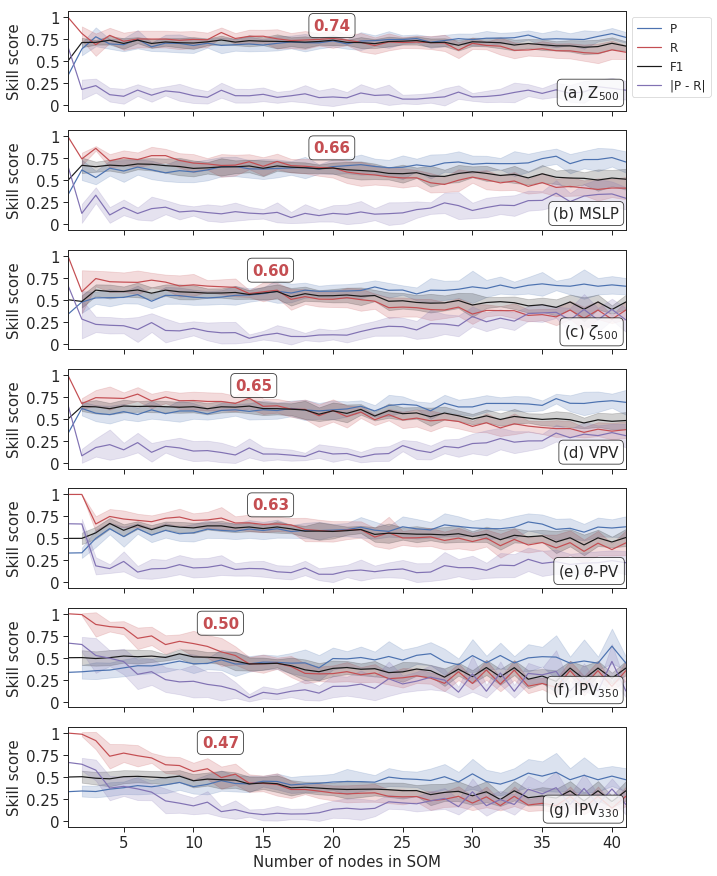

In [11]:


savefig_str = "/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/era5_F1scores"


#sns.set_theme(context='paper',style="ticks",palette="bright")
sns.set_theme(context='paper',style="ticks",)

#sns.set_style("darkgrid", {"xtick.major.size": 18, "ytick.major.size": 8})
#by default the mean and 95% confidence interval are shown
# Plot the responses for different events and regions
#sns.lineplot(x=x_label,y=y_label,hue=legend_label,palette=["b","r","k","m"],
#             style=legend_label,style_order=["F1","pr","abs(pr - rc)","rc"],
#             data=df_msl)

df_arr = [df_z, df_msl, df_rel_vort, df_VPV, df_pt_pv2, df_pv350, df_pv330]
num_rows=len(df_arr)



fig, axs = plt.subplots(nrows=num_rows, ncols=1, sharex=True, sharey=True, figsize=(10,15))
for i, var in enumerate(df_arr):
    plot_legend = False
    if i == 0:
        plot_legend = True
    plot = sns.lineplot(x=x_label,y=y_label,hue=legend_label,palette=["b","r","k","m"],
             #style=legend_label,style_order=["F1","pr","abs(pr - rc)","rc"],
                        legend=plot_legend,
             data=var, ax = axs[i % num_rows], ci = "sd") 
    
# Plot the number of node clusters
# axs1 = axs[0].twinx()
# axs2 = axs[1].twinx()
# sns.lineplot(x=x_label,y=y_label_numclus,palette=["b"],
#              data=df_numclus_z, ci = "sd", ax = axs1)  
# sns.lineplot(x=x_label,y=y_label_numclus,palette=["b"],
#              data=df_numclus_msl, ci = "sd", ax = axs2)  
    

#plt.xlabel("Culmen Length (mm)")
#plt.ylabel("Culmen Depth (mm)")
# place the legend outside the figure/plot
axs[0].legend(bbox_to_anchor=(1,1), borderaxespad=0.5, fontsize=12)

props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)

fs_caption = 15
fs_vertalign = "top"
caption_loc = (0.86, 0.27)
caption_loc_arr = [(0.885, 0.27), (0.87, 0.24), (0.89, 0.27), (0.888, 0.24), (0.879, 0.26), (0.867, 0.265), (0.86, 0.27)]
caption_labels = ["(a) Z$_{500}$", "(b) MSLP", "(c) $\zeta_{500}$", "(d) VPV", r"(e) $\theta$-PV",
                   "(f) IPV$_{350}$", "(g) IPV$_{330}$"]
F1_labels_loc = [(0.44, 0.93), (0.44, 0.9), (0.33, 0.87), (0.30, 0.91), (0.33, 0.91), (0.24, 0.92), (0.24, 0.92)]
F1_labels = ["0.74", "0.66", "0.60", "0.65", "0.63",
                   "0.50", "0.47"]
#ERA5 Z 0.74 20 nodes
#ERA5 SLP 0.66 20
#ERA5 RV 0.60 16
#ERA5 VPV 0.65 14
#ERA5 theta-PV 0.63 16
#ERA5 IPV 350 0.50 12
#ERA5 IPV 330 0.47 12
#0.61 20 nodes UKRV
#0.63 17 nodes UKSLP
#0.70 UKZ 21 nodes (weird behaviour - rerun/check)

#fig.suptitle("Skill score in ERA5 of SOM-BI")

for i, ax in enumerate(axs):
    ax.set_xlim(1,41) 
    #ax.set_ylim(0.4,0.61)
    ax.set_ylabel("Skill score", fontsize=fs_caption)
    ax.set_yticklabels(["0", "0", "0.25", "0.5" , "0.75", "1"], fontsize=fs_caption)
    ax.text(caption_loc_arr[i][0], caption_loc_arr[i][1], caption_labels[i], transform=ax.transAxes, fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props)
    ax.text(F1_labels_loc[i][0], F1_labels_loc[i][1], F1_labels[i], transform=ax.transAxes, fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props, color = "r", weight="bold")
axs[-1].set_xlabel("Number of nodes in SOM", fontsize=fs_caption)    
axs[-1].set_xticklabels(range(0,45,5), fontsize=fs_caption)    

fig.savefig(f"{savefig_str}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{savefig_str}.pdf", dpi=300, bbox_inches="tight")

In [9]:

def add_col(df, col_name, col_str, orig_col_name='variable'):
    """
    Add a new column to a dataframe so that the legend below can be renamed
    """
    arr = []
    for i in range(len(df[orig_col_name])):
        arr.append(col_str)
    df[col_name] = arr
    return df

col_name_var = "Variable"
col_name_mdl = "Model"
col_str = "zg"
col_str_arr_var = [r"Z$_{500}$", "MSLP", "$\zeta_{500}$", r"Z$_{500}$", "MSLP", "$\zeta_{500}$"]
col_str_arr_mdl = ["ERA5", "ERA5", "ERA5", "UKESM1-0-LL", "UKESM1-0-LL", "UKESM1-0-LL"]
df_tot = df_numclus_z
df_arr = [df_numclus_z, df_numclus_msl, df_numclus_rel_vort, df_numclus_zUK, df_numclus_mslUK, df_numclus_rel_vortUK]
for df, col_str_var, col_str_mdl in zip(df_arr, col_str_arr_var, col_str_arr_mdl):
    df_add = add_col(df, col_name_var, col_str_var)
    df_add = add_col(df, col_name_mdl, col_str_mdl) 
    df_tot=df_tot.append(df_add, sort=True)
    
    
df_tot_ax2 = df_numclus_VPV
df_arr_ax2 = [df_numclus_VPV, df_numclus_pt_pv2, df_numclus_pv350, df_numclus_pv330]

col_str_arr_mdl_ax2 = ["ERA5", "ERA5", "ERA5", "ERA5"]
col_str_arr_var_ax2 = ["VPV", r"$\theta$-PV", "IPV$_{350}$", "IPV$_{330}$"]
#[df_numclus_z, df_numclus_msl, df_numclus_rel_vort, df_numclus_zUK, df_numclus_mslUK, df_numclus_rel_vortUK]   
for df, col_str_var, col_str_mdl in zip(df_arr_ax2, col_str_arr_var_ax2, col_str_arr_mdl_ax2):
    df_add = add_col(df, col_name_var, col_str_var)
    df_add = add_col(df, col_name_mdl, col_str_mdl) 
    df_tot_ax2=df_tot_ax2.append(df_add, sort=True)    
    
    

<Figure size 1080x1080 with 0 Axes>

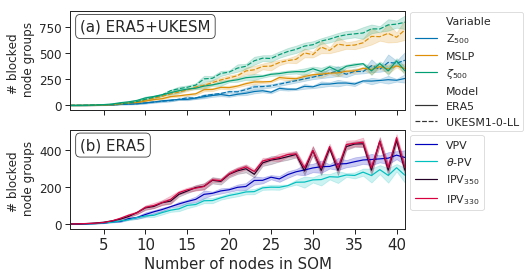

In [12]:
fig = plt.figure(figsize=(15,15))
sns.set_theme(context='paper',style="ticks",palette="colorblind")
savefig_str = "/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/era5UK_nodeclusnonPV"
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False)
sns.lineplot(x=x_label,y=y_label_numclus,hue=col_name_var,style=col_name_mdl,
             data=df_tot, ci = "sd", ax = ax1, legend=True)

ylabels = ["# blocked \n node groups", "# blocked \n node groups"]
ax2.set_xlabel("Number of nodes")
fs_leg = 11
#sns.set_palette("rainbow")
sns.lineplot(x=x_label,y=y_label_numclus,hue=col_name_var,palette=[(0,0,0.75),(0,0.75,0.75),(0.15,0,0.15),(0.85,0,0.25)],
             data=df_tot_ax2
             , ci = "sd", ax = ax2, legend=True)
ax2.legend(bbox_to_anchor=(1,1), fontsize=fs_leg)
ax1.legend(bbox_to_anchor=(1,1.05), fontsize=fs_leg)

caption_labels = ["(a) ERA5+UKESM", "(b) ERA5"]
caption_loc = [0.03, 0.92]#,(0.83, 0.17)]
for i, ax in enumerate([ax1, ax2]):
    ax.tick_params(axis='y', labelsize=fs_caption-3)
    ax.set_ylabel(ylabels[i], fontsize=fs_caption-3)
    ax.set_xlim(1,41)
    #ax.set_ylim(128,132)
    ax.text(caption_loc[0], caption_loc[1], caption_labels[i], transform=ax.transAxes,
            fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props)
    
ax2.set_xlabel("Number of nodes in SOM", fontsize=fs_caption)    
ax2.set_xticklabels(range(0,45,5), fontsize=fs_caption)        
#ax3.plot(nodes, avg_nn)    - if you want to plot this but it doesn't line up well

fig.savefig(f"{savefig_str}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{savefig_str}.pdf", dpi=300, bbox_inches="tight")


## UKESM Trend plots

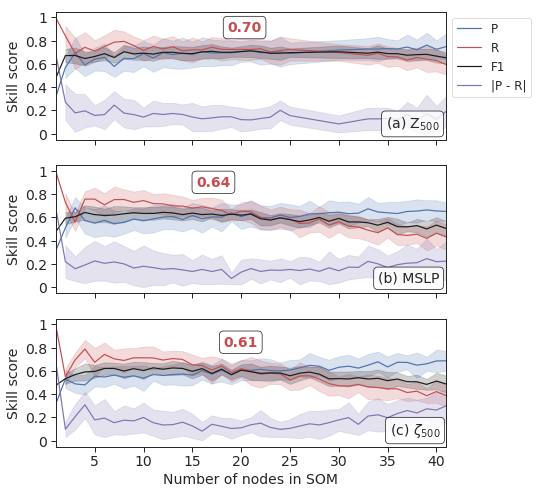

In [13]:


savefig_str = "/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/UKESM1-0-LL_F1scores"


sns.set_theme(context='paper',style="ticks",palette="bright")
sns.set_theme(context='paper',style="ticks",)

#sns.set_style("darkgrid", {"xtick.major.size": 18, "ytick.major.size": 8})
#by default the mean and 95% confidence interval are shown
# Plot the responses for different events and regions
#sns.lineplot(x=x_label,y=y_label,hue=legend_label,palette=["b","r","k","m"],
#             style=legend_label,style_order=["F1","pr","abs(pr - rc)","rc"],
#             data=df_msl)

df_arr = [df_zUK, df_mslUK, df_rel_vortUK]
num_rows=len(df_arr)



fig, axs = plt.subplots(nrows=num_rows, ncols=1, sharex=True, sharey=True, figsize=(7,8))
for i, var in enumerate(df_arr):
    plot_legend = False
    if i == 0:
        plot_legend = True
    plot = sns.lineplot(x=x_label,y=y_label,hue=legend_label,palette=["b","r","k","m"],
             #style=legend_label,style_order=["F1","pr","abs(pr - rc)","rc"]
                        legend=plot_legend,
             data=var, ax = axs[i % num_rows], ci = "sd") 

# place the legend outside the figure/plot
axs[0].legend(bbox_to_anchor=(1,1), borderaxespad=0.5, fontsize=12)

props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)

fs_caption = 14
fs_vertalign = "top"

caption_loc = (0.83, 0.2)
caption_loc_arr = [(0.845, 0.19), (0.825, 0.17), (0.855, 0.195)]
caption_labels = ["(a) Z$_{500}$", "(b) MSLP", "(c) $\zeta_{500}$"]


F1_labels_loc = [(0.44, 0.93), (0.36, 0.92), (0.43, 0.87)]
F1_labels = ["0.70", "0.64", "0.61"]
#0.61 20 nodes UKRV
#0.63 17 nodes UKSLP
#0.70 UKZ 21 nodes (weird behaviour - rerun/check)

for i, ax in enumerate(axs):
    ax.set_xlim(1,41)
    #ax.set_ylim(0.60,0.65)
    ax.set_ylabel("Skill score", fontsize=fs_caption)
    ax.set_yticklabels(["0", "0", "0.2", "0.4", "0.6" , "0.8", "1"], fontsize=fs_caption)    
    ax.text(caption_loc_arr[i][0], caption_loc_arr[i][1], caption_labels[i], transform=ax.transAxes, fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props)
    ax.text(F1_labels_loc[i][0], F1_labels_loc[i][1], F1_labels[i], transform=ax.transAxes, fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props, color = "r", weight="bold")
axs[-1].set_xlabel("Number of nodes in SOM", fontsize=fs_caption)    
axs[-1].set_xticklabels(range(0,45,5), fontsize=fs_caption) 


fig.savefig(f"{savefig_str}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{savefig_str}.pdf", dpi=300, bbox_inches="tight")

## Nearest neighbours per node
Possible  explanaition for some of the variance in the numclus plots 

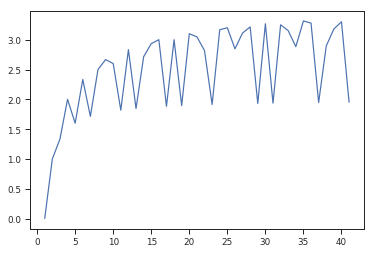

In [127]:
#count the avarege number of nearest neighbours for each SOM number
#this variable seems to explain some of the variance in the data
#in general when there is a large avg number of nn's per node
#this decreases the number of blocked node clusters
nodes = np.arange(1,42)
#maximum number of rows in SOM - set to the largest number of 
max_rows = 8 
avg_nn, rowcol_arr = [], []
for n in nodes:
    modulo_arr = np.array([n%c for c in range(2,8)])
    floor_arr = np.array([n//c for c in range(2,8)])
    #find the value where n%c = 0 and n//c is in the middle of possible values
    if 0 in modulo_arr:
        floor_mod0=floor_arr[np.where(modulo_arr == 0)[0]]
        floor_mod_idx = [int(len(floor_mod0)/2) if n != 48 else int(len(floor_mod0)/2)+1] #exception for n = 48 hard coded here - will need to fix if extending to node number > 50
        row = floor_mod0[floor_mod_idx[0]]
        col = n/row
        if n == 4: #note sure why 2x2 not working but also hard-coded here 
            row, col = 2, 2
        #print(f"rowxcol = {row}x{col}")
        if col != int(col):
            print("ERROR - column non-integer value!")
        else:
            col = int(col)
        if row > 1:
            avg_nn_val = (2*(2*2 + 3*(col - 2))    #first set of terms counts nns for top and bottom rows
                + (row - 2)*(6 + 4*(col - 2)) )/n  #second set of terms counts nns for middle rows (present for row > 2)
        else:
            avg_nn_val = 2*(n-1)/n
        rowcol_arr.append((max(row, col), min(row, col)))
    else:
        col = 1
        avg_nn_val = 2*(n-1)/n
        row = n
        rowcol_arr.append((max(row, col), min(row, col)))
    avg_nn.append(avg_nn_val)
plt.plot(nodes, avg_nn)


In [14]:
files_list=sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/*pr_rc_swapERA5*"))

# #/rds/general/project/nowack_graven/live/carl_som_index/data/era5/z/SOM_data_occur_tot_era5_reanal_5x2_EUR_1979-2019_JJA_extd_z_swapUKESM1-0-LL.nc
# files_list=sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/era5/zg/crossval/F1_cv/10-fold/*swapUKESM*"))

# files_toremove=["/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_9x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_36x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_34x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_32x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_30x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_2x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_28x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_26x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_24x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_22x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_20x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_18x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_16x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_14x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc",
# "/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_12x1_EUR_100yrs_JJA_extd_zg_LTDManom_pr_rc_swapERA5.nc"]


#for file in files_toremove:
#    files_list.remove(file)

#for file in files_list:
#    if "x1_" in file:
#        files_list.remove(file)

files_list=sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/*swapUKESM3*"))
df_z_swapERA5, df_numclus_z_swapERA5 = create_sns_df("z", k, files_list=files_list, rem_nonopt_SOM_arr=True)

UnboundLocalError: local variable 'yrs_train' referenced before assignment

<Figure size 432x288 with 0 Axes>

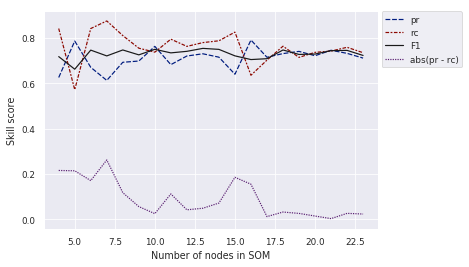

In [7]:

fig = plt.figure()

savefig_str = "/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/UKESM1-0-LL_cv_nodenumvsskill_mslz500_10fld_F1max_clus_swapUKESM"


sns.set_theme(context='paper',style="darkgrid",palette="dark")


sns.set_style("darkgrid", {"xtick.major.size": 18, "ytick.major.size": 8})
#by default the mean and 95% confidence interval are shown
# Plot the responses for different events and regions
#sns.lineplot(x=x_label,y=y_label,hue=legend_label,palette=["b","r","k","m"],
#             style=legend_label,style_order=["F1","pr","abs(pr - rc)","rc"],
#             data=df_msl)


fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
for i, var in enumerate([df_z_swapERA5]):
    plot_legend = False
    if i == 0:
        plot_legend = True
    row = i//2
    pos = i % 2
    plot = sns.lineplot(x=x_label,y=y_label,hue=legend_label,palette=["b","r","k","m"],
             style=legend_label,style_order=["F1","pr","abs(pr - rc)","rc"],legend=plot_legend,
             data=var, ci = "sd") #ax = axs[i % 2]
    
# Plot the number of node clusters
# axs1 = axs[0].twinx()
# axs2 = axs[1].twinx()
# sns.lineplot(x=x_label,y=y_label_numclus,palette=["b"],
#              data=df_numclus_z, ci = "sd", ax = axs1)  
# sns.lineplot(x=x_label,y=y_label_numclus,palette=["b"],
#              data=df_numclus_msl, ci = "sd", ax = axs2)  
    

#plt.xlabel("Culmen Length (mm)")
#plt.ylabel("Culmen Depth (mm)")
# place the legend outside the figure/plot
axs.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)

fs_caption = 12
fs_vertalign = "top"
caption_loc = (0.83, 0.17)
caption_labels = ["(a) Z$_{500}$", "(b) MSLP"]

#fig.suptitle("Skill score in UKESM1-0-LL piControl when using SOM trained on ERA5 1979-2019")

#for i, ax in enumerate(axs):
#axs.text(caption_loc[0], caption_loc[1], caption_labels[i], transform=axs.transAxes, fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props)
#axs.set_xlim(10,22)
#axs.set_ylim(0.71,0.76)
    
fig.savefig(f"{savefig_str}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{savefig_str}.pdf", dpi=300, bbox_inches="tight")

Text(0.5,0.98,'ERA5 SOM-BI trained 1979-2019 \n number of node clusters associated with blocking')

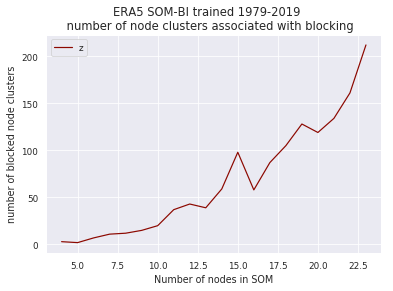

In [8]:
fig = plt.figure()
sns.set_theme(context='paper',style="darkgrid",palette="dark")
savefig_str = "/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/UKESM1-0-LL_cv_nodenumvsskill_mslz500_10fld_F1max_num_nodeclus_swapUKESM"
sns.lineplot(x=x_label,y=y_label_numclus,hue="variable",palette=["r"],style="variable",
             data=df_numclus_z_swapERA5, ci = "sd")
plt.legend()

fig.suptitle("ERA5 SOM-BI trained 1979-2019 \n number of node clusters associated with blocking")
#plt.xlim(20.5,21.5)
#plt.ylim(133,137)

#fig.savefig(f"{savefig_str}.png", dpi=300, bbox_inches="tight")
#fig.savefig(f"{savefig_str}.pdf", dpi=300, bbox_inches="tight")


In [9]:
yrstrain_files=sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/zg/crossval/F1_cv/10-fold/training_yrs/*cv_crossvsF1_10-fold_UKESM1-0-LL_r1i1p1f2_5x4_EUR_10yrs_JJA_extd_zg_*"))
df_z_yrstrain_UKESM, df_numclus_z_yrstrain_UKESM = create_sns_df("z", k, files_list=yrstrain_files)

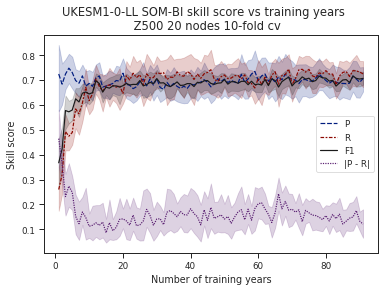

In [24]:
fig = plt.figure()
#vars_label, yrs_label
sns.set_theme(context='paper',style="ticks",palette="dark")
savefig_str = "/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/yrstrain_skill_comp_UKESM"
#sns.lineplot(x=x_label,y=y_label_numclus,hue=yrs_label,palette=["r","b"],style=yrs_label,
#             data=df_z_yrstrain_ERA5, ci = "sd")
sns.lineplot(x=yrs_label,y=y_label,style=legend_label,hue=legend_label,palette=["b","r","k","m"],style_order=["F1","P","|P - R|","R"],
    data=df_z_yrstrain_UKESM)
plt.legend()

fig.suptitle("UKESM1-0-LL SOM-BI skill score vs training years \n Z500 20 nodes 10-fold cv")
#plt.xlim(20,25)

fig.savefig(f"{savefig_str}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{savefig_str}.pdf", dpi=300, bbox_inches="tight")


In [11]:
yrstrain_files=sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/training_yrs/*cv_crossvsF1_10-fold_era5_reanal_5x4_EUR_4yrs_JJA_extd_z_LTDManom_pr_rc*"))
df_z_yrstrain_ERA5, df_numclus_z_yrstrain_ERA5 = create_sns_df("z", k, files_list=yrstrain_files)

In [12]:

mdl_var_str = 'model' # variable to define column with model label
mdl_arr = []
mdl_arr += len(df_z_yrstrain_ERA5['Skill score'])*["ERA5"]
df_z_yrstrain_ERA5[mdl_var_str] = mdl_arr
mdl_arr = []
mdl_arr += len(df_numclus_z_yrstrain_ERA5['variable'])*["ERA5"]
df_numclus_z_yrstrain_ERA5[mdl_var_str] = mdl_arr

mdl_arr = []
mdl_arr += len(df_z_yrstrain_UKESM['Skill score'])*["UKESM"]
df_z_yrstrain_UKESM[mdl_var_str] = mdl_arr
mdl_arr = []
mdl_arr += len(df_numclus_z_yrstrain_UKESM['variable'])*["UKESM"]
df_numclus_z_yrstrain_UKESM[mdl_var_str] = mdl_arr


In [29]:
legend_label

'Skill metric'

No handles with labels found to put in legend.


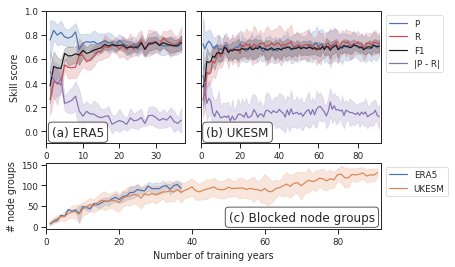

In [49]:
grid = plt.GridSpec(2, 2, wspace=0.1, hspace=0.2, width_ratios=[1, 1.3], height_ratios=[1,0.5])
fig = plt.figure()

#widths = [2, 3, 1.5]
#heights = [1, 3, 2]
#spec5 = fig5.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
#                          height_ratios=heights)
#ax1 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1], sharey=ax1)
ax3 = fig.add_subplot(grid[1, :])
plt.setp(ax2.get_yticklabels(), visible=False)

axs = [ax1, ax2]

#vars_label, yrs_label
#Darkgrid, Whitegrid, Dark, White, Ticks
sns.set_theme(context='paper',style="ticks")#,palette="colorblind")
savefig_str = "/rds/general/user/cmt3718/home/notebooks/SOM/yrstrain_skill_comp"
#sns.lineplot(x=x_label,y=y_label_numclus,hue=yrs_label,palette=["r","b"],style=yrs_label,
#             data=df_z_yrstrain_ERA5, ci = "sd")

#fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True,gridspec_kw={
#                           'width_ratios': [1, 1.4],
#                           'height_ratios': [1,0.5]})

##palette=["b","r","k","m"],
             #style=legend_label,style_order=["F1","pr","abs(pr - rc)","rc"],
for i, var in enumerate([df_z_yrstrain_ERA5, df_z_yrstrain_UKESM]):
    plot_legend = False
    if i == 1:
        plot_legend = True
    row = i//2
    pos = i % 2
#palette=["b","r","k","m"],style_order=["F1","pr","abs(pr - rc)","rc"],
    plot = sns.lineplot(x=yrs_label,y=y_label,hue=legend_label,palette=["b","r","k","m"],style_order=["P","R","F1","|P - R|"],
            data=var, ax = axs[i % 2], legend=plot_legend, ci = "sd")
plt.legend()


axs[1].legend(bbox_to_anchor=(1.0, 1))#,borderaxespad=0)

props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)

fs_caption = 12
fs_vertalign = "top"
caption_loc = [(0.04, 0.13), (0.03, 0.13), (0.545, 0.27)]
caption_labels = ["(a) ERA5", "(b) UKESM", "(c) Blocked node groups"]
for i, ax in enumerate(axs):
    ax.text(caption_loc[i][0], caption_loc[i][1], caption_labels[i], transform=ax.transAxes, fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props)
    #ax.set_xlim(0,38)


    
    
sns.lineplot(x="Number of training years",y=y_label_numclus,hue="model",#palette=["b","r","k","m"],style_order=["P","R","F1","|P - R|"],
             data=df_numclus_z_yrstrain_ERA5.append(df_numclus_z_yrstrain_UKESM), ci = "sd", ax=ax3)    
ax3.legend(bbox_to_anchor=(1.0, 1))
ax3.text(caption_loc[2][0], caption_loc[2][1], caption_labels[2], transform=ax3.transAxes, fontsize=fs_caption, verticalalignment=fs_vertalign, bbox=props)

ax3.set_ylabel("# node groups")
ax3.set_xlim(0,92)
ax2.set_xlim(0,92)
ax1.set_xlim(0,38)
ax3.set_yticks([0,50,100,150])
#fig.suptitle("SOM-BI skill score vs training years \n Z500 20 nodes 10-fold cv")
#plt.xlim(20,25)

#fig.tight_layout()

fig.savefig(f"{savefig_str}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{savefig_str}.pdf", dpi=300, bbox_inches="tight")


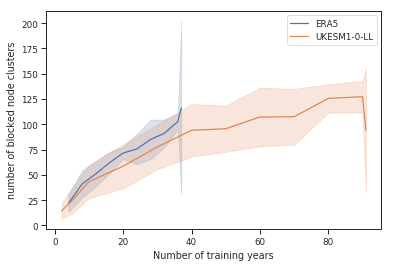

In [73]:
fig = plt.figure()
#sns.set_theme(context='paper',style="ticks",palette="colorblind")
#sns.set_theme(context='paper',style="darkgrid",palette="dark")
savefig_str = "/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/era5_cv_nodenumvsskill_mslz500_10fld_F1max_num_nodeclus"
sns.lineplot(x="Number of training years",y=y_label_numclus,hue="model",#palette=["r","b"],#style="variable",
             data=df_numclus_z_yrstrain_ERA5.append(df_numclus_z_yrstrain_UKESM), ci = "sd")
plt.legend()

#fig.suptitle("ERA5 SOM-BI \n number of node clusters associated with blocking")
#plt.xlim(89.5,90)
#plt.ylim(127,127.5)
#fig.savefig(f"{savefig_str}.png", dpi=300, bbox_inches="tight")
#fig.savefig(f"{savefig_str}.pdf", dpi=300, bbox_inches="tight")


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


<Figure size 432x288 with 0 Axes>

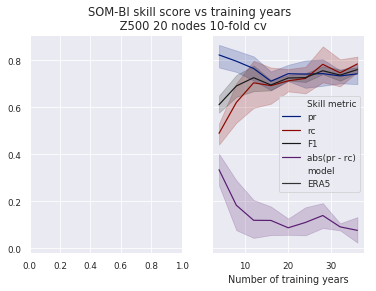

In [31]:
fig = plt.figure()
#vars_label, yrs_label
sns.set_theme(context='paper',style="darkgrid",palette="dark")
savefig_str = "/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/yrstrain_skill_comp"
#sns.lineplot(x=x_label,y=y_label_numclus,hue=yrs_label,palette=["r","b"],style=yrs_label,
#             data=df_z_yrstrain_ERA5, ci = "sd")

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)
# for i, var in enumerate([df_z_yrstrain_ERA5, df_z_yrstrain_UKESM]):
#     plot_legend = False
#     #if i == 0:
#     #plot_legend = True
#     row = i//2
#     pos = i % 2
    
    #plot = sns.lineplot(x=x_label,y=y_label,hue=legend_label,palette=["b","r","k","m"],
    #         style=legend_label,style_order=["F1","pr","abs(pr - rc)","rc"],legend=plot_legend,
    #         data=var, ax = axs[i % 2], ci = "sd") 
    
    #sns.lineplot(x="timepoint", y="signal",
    #         hue="region", style="event",
    #         data=fmri)
#palette=["b","r","k","m"],style_order=["F1","pr","abs(pr - rc)","rc"],
plot = sns.lineplot(x=yrs_label,y=y_label,style=mdl_var_str,hue=legend_label,palette=["b","r","k","m"],#style_order=["F1","pr"],
        data=df_z_yrstrain_ERA5.append(df_z_yrstrain_UKESM))
plt.legend()

fig.suptitle("SOM-BI skill score vs training years \n Z500 20 nodes 10-fold cv")
#plt.xlim(20,25)

fig.savefig(f"{savefig_str}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{savefig_str}.pdf", dpi=300, bbox_inches="tight")


In [157]:
gen_skill_pr=df_z_yrstrain_ERA5['Skill score'][::4]
len(gen_skill_pr)

#, df_numclus_z_yrstrain_ERA5

45

In [ ]:
##/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/cv_crossvsF1_10-fold_era5_reanal_4x4_EUR_4yrs_JJA_extd_z_LTDManom_pr_rc_BMU+.nc
cv_10fold_files=sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/*LTDManom_pr_rc_BMU+.nc*"))

node_num_arr, F1_F1max_10fold, pr_F1max_10fold, rc_F1max_10fold, num_clus_F1max_10fold = [], [], [], [], []
alpha_val = 0.7

for cv in cv_10fold_files[:]:
    row, col = int(cv.split("_")[9].split("x")[0]), int(cv.split("_")[9].split("x")[1])
    node_num = (row*col)
    
    cv = xr.open_dataset(cv)
    node_num_arr.append(node_num)
    ##print(f"node_num = {node_num}, rowxcol = {row}x{col}")
    F1_F1max_10fold.append(float(cv['F1_cv_F1'].mean()))
    pr_F1max_10fold.append(float(cv['pr_cv_F1'].mean()))
    rc_F1max_10fold.append(float(cv['rc_cv_F1'].mean()))    
    num_clus_F1max_10fold.append(float(cv['num_clus_F1'].mean()))
    
    
F1_cv_ds_10fold = xr.Dataset({'node_num': node_num_arr, 'F1_F1max_10fold': F1_F1max_10fold,'pr_F1max_10fold': pr_F1max_10fold, 'rc_F1max_10fold': rc_F1max_10fold,
                       'num_clus_F1max_10fold': num_clus_F1max_10fold}).sortby("node_num")  
          
F1_F1max_10fold = xr.DataArray(data=F1_F1max_10fold, dims=["node_num"], coords=[node_num_arr]).sortby("node_num")
pr_F1max_10fold = xr.DataArray(data=pr_F1max_10fold, dims=["node_num"], coords=[node_num_arr]).sortby("node_num")
rc_F1max_10fold = xr.DataArray(data=rc_F1max_10fold, dims=["node_num"], coords=[node_num_arr]).sortby("node_num")
          
    
fig = plt.figure()


style_arr = ["r+--", "gx--", "m^-", "r+:", "gv:", "m^:"]

plt.title("era5 Z500 BMU+ SOM-BI comparing \n F1 max cluster choice 10-fold", fontsize = 11)#10-fold cv, 

plt.plot(F1_F1max_10fold['node_num'], pr_F1max_10fold, style_arr[0], label = "avg pr", alpha=alpha_val)
plt.plot(F1_F1max_10fold['node_num'], rc_F1max_10fold, style_arr[1], label = "avg rc", alpha=alpha_val)
plt.plot(F1_F1max_10fold['node_num'], F1_F1max_10fold, style_arr[2], label = "avg F1", alpha=alpha_val)

#plt.scatter(F1_F1max_10fold['node_num'][np.where(F1_F1max_10fold==F1_F1max_10fold.max())[0][0]], F1_F1max_10fold.max(), s=50, marker="v", label = "peak F1 score")

plt.plot(F1_F1max_10fold['node_num'], abs(rc_F1max_10fold - pr_F1max_10fold), style_arr[4], label = "abs(avg rc - avg pr)")


##plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['pr_F1max_5fold'], style_arr[3], label = "pr 5-fold")
##plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['rc_F1max_5fold'], style_arr[4], label = "rc 5-fold")
##plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['F1_F1max_5fold'], style_arr[5], label = "max F1 5-fold")



peak_F1_nodenum = F1_F1max_10fold['node_num'][np.where(F1_F1max_10fold==F1_F1max_10fold.max())[0][0]]
crossdiff_F1 = float(F1_F1max_10fold[np.where((abs(rc_F1max_10fold - pr_F1max_10fold))==(abs(rc_F1max_10fold - pr_F1max_10fold)).min())[0][0]])
crossdiff_F1_nodenum = int(F1_F1max_10fold['node_num'][np.where((abs(rc_F1max_10fold - pr_F1max_10fold))==(abs(rc_F1max_10fold - pr_F1max_10fold)).min())[0][0]])

plt.xlabel(f"number of nodes \n \n peak F1 score {float(F1_F1max_10fold.max()):.2f} for {int(peak_F1_nodenum)} nodes \n F1 score for smallest abs(rc - pr) {crossdiff_F1:.2f} for {crossdiff_F1_nodenum} nodes")
plt.ylabel("Skill score")
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(-0.05,1.05)
    
fig.savefig("/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/era5_cv_nodenumvsskill_z500_10fld_F1max_BMU+.png", dpi=300, bbox_inches="tight")    

In [ ]:
F1_F1max_10fold['node_num']

In [ ]:
cv_10fold_files=sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/10-fold/*z_LTDManom_pr_rc.nc*"))

node_num_arr, F1_F1max_10fold, pr_F1max_10fold, rc_F1max_10fold, num_clus_F1max_10fold = [], [], [], [], []
alpha_val = 0.7

for cv in cv_10fold_files[:]:
    row, col = int(cv.split("_")[9].split("x")[0]), int(cv.split("_")[9].split("x")[1])
    node_num = (row*col)
    
    cv = xr.open_dataset(cv)
    node_num_arr.append(node_num)
    ##print(f"node_num = {node_num}, rowxcol = {row}x{col}")
    F1_F1max_10fold.append(float(cv['F1_cv_F1'].mean()))
    pr_F1max_10fold.append(float(cv['pr_cv_F1'].mean()))
    rc_F1max_10fold.append(float(cv['rc_cv_F1'].mean()))    
    num_clus_F1max_10fold.append(float(cv['num_clus_F1'].mean()))
    
    
F1_cv_ds_10fold = xr.Dataset({'node_num': node_num_arr, 'F1_F1max_10fold': F1_F1max_10fold,'pr_F1max_10fold': pr_F1max_10fold, 'rc_F1max_10fold': rc_F1max_10fold,
                       'num_clus_F1max_10fold': num_clus_F1max_10fold}).sortby("node_num")  
          
F1_F1max_10fold = xr.DataArray(data=F1_F1max_10fold, dims=["node_num"], coords=[node_num_arr]).sortby("node_num")
pr_F1max_10fold = xr.DataArray(data=pr_F1max_10fold, dims=["node_num"], coords=[node_num_arr]).sortby("node_num")
rc_F1max_10fold = xr.DataArray(data=rc_F1max_10fold, dims=["node_num"], coords=[node_num_arr]).sortby("node_num")
          
    
fig = plt.figure()


style_arr = ["r+--", "gx--", "m^-", "r+:", "gv:", "m^:"]

plt.title("era5 Z500 SOM-BI comparing \n F1 max cluster choice 10-fold", fontsize = 11)#10-fold cv, 

plt.plot(F1_F1max_10fold['node_num'], pr_F1max_10fold, style_arr[0], label = "avg pr", alpha=alpha_val)
plt.plot(F1_F1max_10fold['node_num'], rc_F1max_10fold, style_arr[1], label = "avg rc", alpha=alpha_val)
plt.plot(F1_F1max_10fold['node_num'], F1_F1max_10fold, style_arr[2], label = "avg F1", alpha=alpha_val)

#plt.scatter(F1_F1max_10fold['node_num'][np.where(F1_F1max_10fold==F1_F1max_10fold.max())[0][0]], F1_F1max_10fold.max(), s=50, marker="v", label = "peak F1 score")

plt.plot(F1_F1max_10fold['node_num'], abs(rc_F1max_10fold - pr_F1max_10fold), style_arr[4], label = "abs(avg rc - avg pr)")


##plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['pr_F1max_5fold'], style_arr[3], label = "pr 5-fold")
##plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['rc_F1max_5fold'], style_arr[4], label = "rc 5-fold")
##plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['F1_F1max_5fold'], style_arr[5], label = "max F1 5-fold")

peak_F1_nodenum = F1_F1max_10fold['node_num'][np.where(F1_F1max_10fold==F1_F1max_10fold.max())[0][0]]
crossdiff_F1 = float(F1_F1max_10fold[np.where((abs(rc_F1max_10fold - pr_F1max_10fold))==(abs(rc_F1max_10fold - pr_F1max_10fold)).min())[0][0]])
crossdiff_F1_nodenum = int(F1_F1max_10fold['node_num'][np.where((abs(rc_F1max_10fold - pr_F1max_10fold))==(abs(rc_F1max_10fold - pr_F1max_10fold)).min())[0][0]])

plt.xlabel(f"number of nodes \n \n peak F1 score {float(F1_F1max_10fold.max()):.2f} for {int(peak_F1_nodenum)} nodes \n F1 score for smallest abs(rc - pr) {crossdiff_F1:.2f} for {crossdiff_F1_nodenum} nodes")


plt.ylabel("Skill score")
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(-0.05,1.05)
    
fig.savefig("/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/era5_cv_nodenumvsskill_z500_10fld_F1max.png", dpi=300, bbox_inches="tight")    

In [ ]:
cv_5fold_files=sorted(glob.glob("/rds/general/project/nowack_graven/live/carl_som_index/data/z/crossval/F1_cv/5-fold/*pr_rc.nc*"))

node_num_arr, F1_F1max_5fold, pr_F1max_5fold, rc_F1max_5fold, num_clus_F1max_5fold = [], [], [], [], []


for cv in cv_5fold_files[:]:
    row, col = int(cv.split("_")[9].split("x")[0]), int(cv.split("_")[9].split("x")[1])
    node_num = (row*col)
    cv = xr.open_dataset(cv)
    node_num_arr.append(node_num)
    F1_F1max_5fold.append(float(cv['F1_cv_F1'].mean()))
    pr_F1max_5fold.append(float(cv['pr_cv_F1'].mean()))
    rc_F1max_5fold.append(float(cv['rc_cv_F1'].mean()))    
    num_clus_F1max_5fold.append(float(cv['num_clus_F1'].mean()))
    
    
F1_cv_ds_5fold = xr.Dataset({'node_num': node_num_arr, 'F1_F1max_5fold': F1_F1max_5fold,'pr_F1max_5fold': pr_F1max_5fold, 'rc_F1max_5fold': rc_F1max_5fold,
                       'num_clus_F1max_5fold': num_clus_F1max_5fold}).sortby("node_num")    
    
fig = plt.figure()


style_arr = ["r+:", "gx:", "m^:"]

plt.title("era5 Z500 SOM-BI comparing \n 5-fold cv, F1 max cluster choice", fontsize = 11)

plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['pr_F1max_5fold'], style_arr[0], label = "pr 5-fold")
plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['rc_F1max_5fold'], style_arr[1], label = "rc 5-fold")

plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['F1_F1max_5fold'], style_arr[2], label = "max F1 5-fold")





plt.xlabel("number of nodes")
plt.ylabel("generalisation score")
plt.legend()

    
    
#fig.savefig("/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/era5_cv_nodenumvsskill_z500_5fld_F1max.png", dpi=300, bbox_inches="tight")

In [ ]:
max gen score is 0.765/0.761 with node number /20

In [ ]:
nodes = [2,3,4,6,9,10,12,15,25]  
F1_F1crossval_5fold = [0.7115214234099093, 0.7181747118534927, 0.7024957775362866, 0.6994649385874692, 0.7078499108920342, 0.7082838723228088, 0.7071286515324241, 0.6995946366308087, 0.35623871854733813]    
F1_F1crossval_10fold = [0.718490645056891, 0.7174140317971357, 0.7070149866349749, 0.7072645562620583, 0.7085439773041551, 0.7106987217372779, 0.7019212793198564, 0.7099761061650025, 0.365968491587547]
F1_F1max_5fold = [0.7115214234099093, 0.7181747118534927, 0.7175320090399524, 0.7116625127974499, 0.7161839979978996, 0.7150852817208999, 0.704214527288977, 0.7048815376195748, 0.3644834622719135]
F1_F1max_10fold = [0.718490645056891, 0.7174140317971357, 0.725948116693246, 0.7185567134820123, 0.7175375898552093, 0.7171537185955678, 0.7086354299612823, 0.7200195487923496, 0.37307218289348576]

style_arr = ["r+-", "gx--", "m^-", "bv--"]

fig = plt.figure()

plt.title("era5 Z500 SOM-BI comparing \n node number, train/test split and choice of blocking clusters", fontsize = 11)

plt.plot(nodes[:-1], F1_F1crossval_5fold[:-1], style_arr[0], label = "cross point pr rc 5-fold")
plt.plot(nodes[:-1], F1_F1crossval_10fold[:-1], style_arr[1], label = "cross point pr rc 10-fold")
plt.plot(nodes[:-1], F1_F1max_5fold[:-1], style_arr[2], label = "max F1 5-fold")
plt.plot(nodes[:-1], F1_F1max_10fold[:-1], style_arr[3], label = "max F1 10-fold")
plt.xlabel("node number")
plt.ylabel("generalisation score")
plt.legend()



fig.savefig("/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/era5_cv_nodenumvsgen_cv_blo_clus_fixed.png", dpi=300, bbox_inches="tight")

In [ ]:
fig = plt.figure()

num_clus_tot = np.concatenate([num_clus_10fold, num_clus_5fold, num_clus_4fold])
F1_test_tot = np.concatenate([F1_test_10fold, F1_test_5fold, F1_test_4fold])

col_5fld="r"
col_4fld="b"
col_10fld="m"

plt.title("era5 zg SOM-BI cross-validation")

slope_10fld, intercept_10fld, r_value_10fld, p_value_10fld, std_err_10fld = stats.linregress(num_clus_10fold, F1_test_10fold)
slope_5fld, intercept_5fld, r_value_5fld, p_value_5fld, std_err_5fld = stats.linregress(num_clus_5fold, F1_test_5fold)
slope_4fld, intercept_4fld, r_value_4fld, p_value_4fld, std_err_4fld = stats.linregress(num_clus_4fold, F1_test_4fold)


slope, intercept, r_value, p_value, std_err = stats.linregress(num_clus_tot, F1_test_tot)

plt.plot(num_clus_tot, intercept + slope*num_clus_tot,  label=f'linear fit \nR$^2$ = {(r_value**2):.2f} pval = {(p_value):.2f}')

plt.scatter(num_clus_10fold, F1_test_10fold, marker = "o", color = col_10fld, label = f"10 fold cv (10 years test) \n generalisation skill {np.mean(F1_test_10fold):.2f} \n")
#plt.plot(num_clus_10fold, intercept_10fld + slope_10fld*np.array(num_clus_10fold), col_10fld, label=f'10 fld rsq {(r_value_10fld**2):.2f} pval {(p_value_10fld):.2f} \n')
plt.scatter(num_clus_5fold, F1_test_5fold, marker="x", color = col_5fld, label = f"5 fold cv (8 years test) \n generalisation skill {np.mean(F1_test_5fold):.2f} \n")
#plt.plot(num_clus_5fold, intercept_5fld + slope_5fld*np.array(num_clus_5fold), col_5fld, label=f'5 fld rsq {(r_value_5fld**2):.2f} pval {(p_value_5fld):.2f} \n')
plt.scatter(num_clus_4fold, F1_test_4fold, marker = "^", color = col_4fld, label = f"4 fold cv (4 years test) \n generalisation skill {np.mean(F1_test_4fold):.2f} \n")
#plt.plot(num_clus_4fold, intercept_4fld + slope_4fld*np.array(num_clus_4fold), col_4fld, label=f'4 fld rsq {(r_value_4fld**2):.2f} pval {(p_value_4fld):.2f} \n \n')


plt.legend(bbox_to_anchor = (1.55,1))
plt.title("era5 zg SOM-BI cross-validation")
plt.ylabel("F1 score in test data")
plt.xlabel("Number of clusters identified with blocking")

fig.savefig("/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/era5_cv_crossval_scatter_F1_clusnumvstest_linfit.png", dpi=300, bbox_inches="tight")

/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=20, right=20
  'left=%s, right=%s') % (left, right))


(19.98, 20.02)

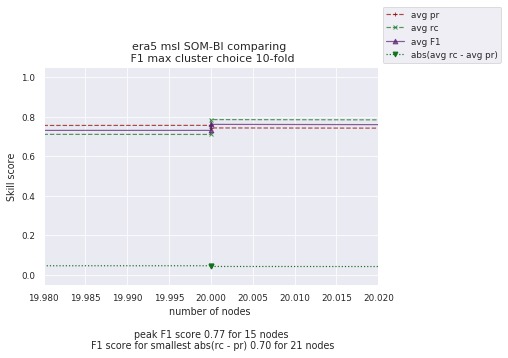

In [32]:

zg_str = "z"#"msl"
cv_10fold_files=sorted(glob.glob(f"/rds/general/project/nowack_graven/live/carl_som_index/data/{zg_str}/crossval/F1_cv/10-fold/*{zg_str}_LTDManom_pr_rc.nc*"))

node_num_arr, F1_F1max_10fold, pr_F1max_10fold, rc_F1max_10fold, num_clus_F1max_10fold = [], [], [], [], []
alpha_val = 0.7

for cv in cv_10fold_files[:]:
    row, col = int(cv.split("_")[9].split("x")[0]), int(cv.split("_")[9].split("x")[1])
    node_num = (row*col)
    
    cv = xr.open_dataset(cv)
    node_num_arr.append(node_num)
    ##print(f"node_num = {node_num}, rowxcol = {row}x{col}")
    F1_F1max_10fold.append(float(cv['F1_cv_F1'].mean()))
    pr_F1max_10fold.append(float(cv['pr_cv_F1'].mean()))
    rc_F1max_10fold.append(float(cv['rc_cv_F1'].mean()))    
    num_clus_F1max_10fold.append(float(cv['num_clus_F1'].mean()))
    
    
F1_cv_ds_10fold = xr.Dataset({'node_num': node_num_arr, 'F1_F1max_10fold': F1_F1max_10fold,'pr_F1max_10fold': pr_F1max_10fold, 'rc_F1max_10fold': rc_F1max_10fold,
                       'num_clus_F1max_10fold': num_clus_F1max_10fold}).sortby("node_num")  
          
F1_F1max_10fold = xr.DataArray(data=F1_F1max_10fold, dims=["node_num"], coords=[node_num_arr]).sortby("node_num")
pr_F1max_10fold = xr.DataArray(data=pr_F1max_10fold, dims=["node_num"], coords=[node_num_arr]).sortby("node_num")
rc_F1max_10fold = xr.DataArray(data=rc_F1max_10fold, dims=["node_num"], coords=[node_num_arr]).sortby("node_num")
          
    
fig = plt.figure()


style_arr = ["r+--", "gx--", "m^-", "r+:", "gv:", "m^:"]

plt.title("era5 msl SOM-BI comparing \n F1 max cluster choice 10-fold", fontsize = 11)#10-fold cv, 

plt.plot(F1_F1max_10fold['node_num'], pr_F1max_10fold, style_arr[0], label = "avg pr", alpha=alpha_val)
plt.plot(F1_F1max_10fold['node_num'], rc_F1max_10fold, style_arr[1], label = "avg rc", alpha=alpha_val)
plt.plot(F1_F1max_10fold['node_num'], F1_F1max_10fold, style_arr[2], label = "avg F1", alpha=alpha_val)

#plt.scatter(F1_F1max_10fold['node_num'][np.where(F1_F1max_10fold==F1_F1max_10fold.max())[0][0]], F1_F1max_10fold.max(), s=50, marker="v", label = "peak F1 score")

plt.plot(F1_F1max_10fold['node_num'], abs(rc_F1max_10fold - pr_F1max_10fold), style_arr[4], label = "abs(avg rc - avg pr)")


##plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['pr_F1max_5fold'], style_arr[3], label = "pr 5-fold")
##plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['rc_F1max_5fold'], style_arr[4], label = "rc 5-fold")
##plt.plot(F1_cv_ds_5fold['node_num'], F1_cv_ds_5fold['F1_F1max_5fold'], style_arr[5], label = "max F1 5-fold")



peak_F1_nodenum = F1_F1max_10fold['node_num'][np.where(F1_F1max_10fold==F1_F1max_10fold.max())[0][0]]
crossdiff_F1 = float(F1_F1max_10fold[np.where((abs(rc_F1max_10fold - pr_F1max_10fold))==(abs(rc_F1max_10fold - pr_F1max_10fold)).min())[0][0]])
crossdiff_F1_nodenum = int(F1_F1max_10fold['node_num'][np.where((abs(rc_F1max_10fold - pr_F1max_10fold))==(abs(rc_F1max_10fold - pr_F1max_10fold)).min())[0][0]])

plt.xlabel(f"number of nodes \n \n peak F1 score {float(F1_F1max_10fold.max()):.2f} for {int(peak_F1_nodenum)} nodes \n F1 score for smallest abs(rc - pr) {crossdiff_F1:.2f} for {crossdiff_F1_nodenum} nodes")
plt.ylabel("Skill score")
plt.legend(bbox_to_anchor=(1,1))

plt.ylim(-0.05,1.05)

#plt.xlim(20,20)
#fig.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/SOM-BI/era5_cv_nodenumvsskill_{zg_str}_10fld_F1max.png", dpi=300, bbox_inches="tight")    

In [ ]:
0.761 F1 score for 5x4 nodes seems to perform better than 21 nodes has pr - rc of 0.042296 which is close to the minimum value of 0.019696


In [30]:
crossdiff_F1, crossdiff_F1_nodenum

(0.7610178986050604, 20)

In [31]:
rc_F1max_10fold - pr_F1max_10fold

<xarray.DataArray (node_num: 2)>
array([0.042296, 0.042296])
Coordinates:
  * node_num  (node_num) int64 20 20

In [33]:
rc_F1max_10fold - pr_F1max_10fold

<xarray.DataArray (node_num: 39)>
array([ 0.641739,  0.17519 , -0.186207,  0.109397,  0.168579,  0.028811,
        0.068967,  0.054684,  0.153706,  0.05212 ,  0.03193 ,  0.072994,
        0.083479,  0.061249,  0.145933,  0.054456,  0.070355,  0.075387,
        0.077046,  0.03584 ,  0.105508,  0.052084,  0.047944,  0.026592,
        0.036408, -0.045907,  0.042296,  0.019696,  0.050925, -0.023405,
       -0.022106, -0.086637, -0.02315 , -0.086354, -0.071508, -0.106358,
       -0.100906, -0.191478, -0.200686])
Coordinates:
  * node_num  (node_num) int64 1 2 3 4 4 5 6 6 7 ... 24 25 26 28 30 32 34 36 38